In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, iirnotch, filtfilt
import pywt
import numpy as np
from statsmodels.robust import mad

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def read_signals(data_dir, channel):
    sigs = []
    titles = []
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        titles.append(file.split("/")[-1])
        
        with open(file_path, "r") as f:
            lines = f.readlines()
            signal = []
            for i, l in enumerate(lines):
                try:
                    reading = int(l.split(',')[channel+1])
                    if(reading < 1023):
                        signal.append(reading)
                except:
                    print(i)
            sigs.append(np.array(signal))
    return sigs, titles

In [4]:
ch1_sigs, titles = read_signals("/content/drive/My Drive/GP/Collected-data/2-channels/araby", 0)
ch2_sigs, titles = read_signals("/content/drive/My Drive/GP/Collected-data/2-channels/araby", 1)

0
0


In [5]:
def visualize_sigs(signals, titles, figsize=(20, 10)):
    fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].set_title(titles[i])
    plt.tight_layout()
#titles=[]
def visualize_binary_sigs(binary_signals, signals, titles = titles, figsize = (20,100)):
    fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].plot(binary_signals[i])
        ax[i].set_title(titles[i])
    plt.tight_layout()
    
def binarize(signals):
    return signals - np.average(signals)

def overlay_sigs(sigs_raw, sigs_proc, sub_titles, figtitle, labels, figsize=(20, 10)):
    n_sigs = len(sigs_raw)
    fig, ax = plt.subplots(n_sigs, figsize=figsize)
    for i in range(n_sigs): 
        ax[i].plot(sigs_raw[i], color="r", label=labels[0])
        ax[i].plot(sigs_proc[i], color="b", label=labels[1])
        ax[i].set_title(sub_titles[i])
        ax[i].legend()
    fig.suptitle(figtitle)
    plt.tight_layout()

def denoise_TKEO(signal):
    tkeo_sig = (np.square(signal[1:-1]) - signal[:-2] * signal[2:])
    return tkeo_sig

def get_baseline(signal, k=3, t=5, fs=1000):
    baseline_end = t * fs
    mean = np.mean(signal[:baseline_end])
    return mean

def get_threshold(signal, k, t=5, fs=1000):
    baseline_end = t * fs
    mean = np.mean(signal[:baseline_end])
    std = np.std(signal[:baseline_end])
    thresh = mean + std*k
    return thresh

def get_thresholds_2_channels(ch1, ch2, k=1):
    ch1_thresh = get_threshold(ch1, k)
    ch2_thresh = get_threshold(ch2, k)
    if(ch1_thresh > ch2_thresh):
        thresh2 = get_threshold(ch1, 0)
    else:
        thresh2 = get_threshold(ch2, 0)
    return max(ch1_thresh, ch2_thresh), thresh2

def remove_baseline(signal, mean):
    return signal - mean

def binarize_signal(signal, thresh):
    return signal > thresh

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y
    
def notch_filter(data, f=50, Q=30, fs=1000):
    b, a = iirnotch(f, Q, fs)
    y = filtfilt(b, a, data)
    return y
def get_binary_label_sig(signal, threshold):
    binary_signal = []
    for i in range(0, len(signal)):
        if signal[i] >= threshold:
            binary_signal.append(1)
        else:
            binary_signal.append(0)
    return binary_signal

In [6]:
overlay_sigs(ch1_sigs, ch2_sigs, titles, "S", labels=["Channel 1", "Channel 2"], 
             figsize=(40,100))

In [ ]:
sigs, titles = read_signals("/content/drive/My Drive/GP/Collected-data/lobna-signals", 0)
visualize_sigs(sigs, titles)

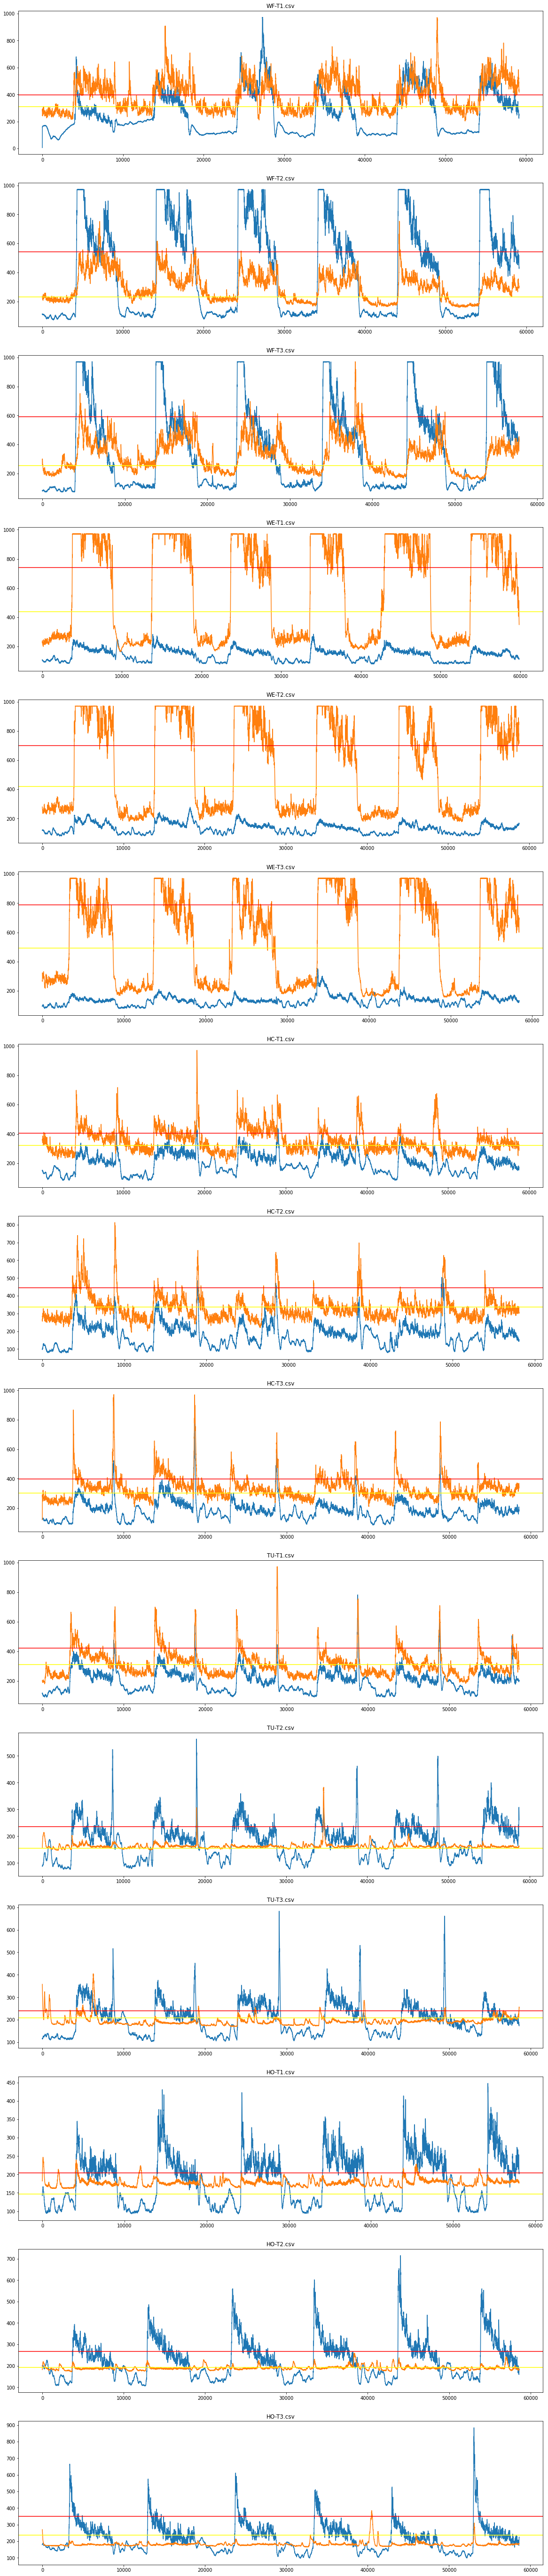

In [7]:
thresholds = [get_thresholds_2_channels(s1, s2, k=1) for s1, s2 in zip(ch1_sigs, ch2_sigs)]

n_plots = len(ch1_sigs)
fig, ax = plt.subplots(n_plots, 1, figsize = (20,100))
for i in range(n_plots):
    ax[i].plot(ch1_sigs[i])
    ax[i].plot(ch2_sigs[i])
    ax[i].axhline(thresholds[i][0], color='red')
    ax[i].axhline(thresholds[i][1], color='yellow')
    ax[i].set_title(titles[i])

In [8]:
def rectifying(signals, frequency_rate = 1000):
    rect_signal = np.absolute(signals)
    rect_signal = average_moving(rect_signal, frequency_rate / 10)
    return rect_signal
def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
    
def denoise_TKEO(signal):
    tkeo_sig = (np.square(signal[1:-1]) - signal[:-2] * signal[2:])
    return tkeo_sig

def smoothing_values(frequency_rate = 1000, smooth_precentage = 20):
    smooth_precentage = smooth_precentage
    return int((smooth_precentage/100) * frequency_rate)

def average_moving(sig, wind_size):
    wind_size = int(wind_size)
    ret = np.cumsum(sig, dtype=float)
    ret[wind_size:] = ret[wind_size:] - ret[:-wind_size]
    return np.concatenate((np.zeros(wind_size - 1), ret[wind_size - 1:] / wind_size))
def Smoothing(signal, smoothing_value):
    smooth_signal = []
    #smoothing_value = smoothing_values()
    for i in range(0, len(signal)):
        if smoothing_value < i < len(signal) - smoothing_value:
            smooth_signal.append(np.mean(signal[i - smoothing_value:i + smoothing_value]))
        else:
            smooth_signal.append(0)
    return smooth_signal

In [9]:
def find_onsets(signal=None, sampling_rate=1000., size=0.05, threshold=None):
    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    # full-wave rectification
    fwlo = np.abs(signal)

    # smooth
    size = int(sampling_rate * size)
    # mvgav, _ = st.smoother(signal=fwlo,
    #                        kernel='boxzen',
    #                        size=size,
    #                        mirror=True)
    mvgav = fwlo

    # threshold
    if threshold is None:
        aux = np.abs(mvgav)
        threshold = 1.2 * np.mean(aux) + 2.0 * np.std(aux, ddof=1)

    # find onsets
    length = len(signal)
    start = np.nonzero(mvgav > threshold)[0]
    stop = np.nonzero(mvgav <= threshold)[0]

    onsets = np.union1d(np.intersect1d(start - 1, stop),
                        np.intersect1d(start + 1, stop))

    if np.any(onsets):
        if onsets[-1] >= length:
            onsets[-1] = length - 1

    return (onsets)

In [10]:
bin_sig1 = [binarize(sig) for sig in ch1_sigs]
filt = [butter_bandpass_filter(sig, 30, 300) for sig in bin_sig1]
filt = [sig[30:] for sig in filt]
tkeo_sigs = [denoise_TKEO(sig) for sig in filt]
rect_signal = [rectifying(sig) for sig in tkeo_sigs]
smoothing_value = smoothing_values()
sm_sig1 = [Smoothing(sig, smoothing_value) for sig in rect_signal]

In [11]:
bin_sig2 = [binarize(sig) for sig in ch2_sigs]
filt = [butter_bandpass_filter(sig, 30, 300) for sig in bin_sig2]
filt = [sig[30:] for sig in filt]
tkeo_sigs = [denoise_TKEO(sig) for sig in filt]
rect_signal = [rectifying(sig) for sig in tkeo_sigs]
smoothing_value = smoothing_values()
sm_sig2 = [Smoothing(sig, smoothing_value) for sig in rect_signal]

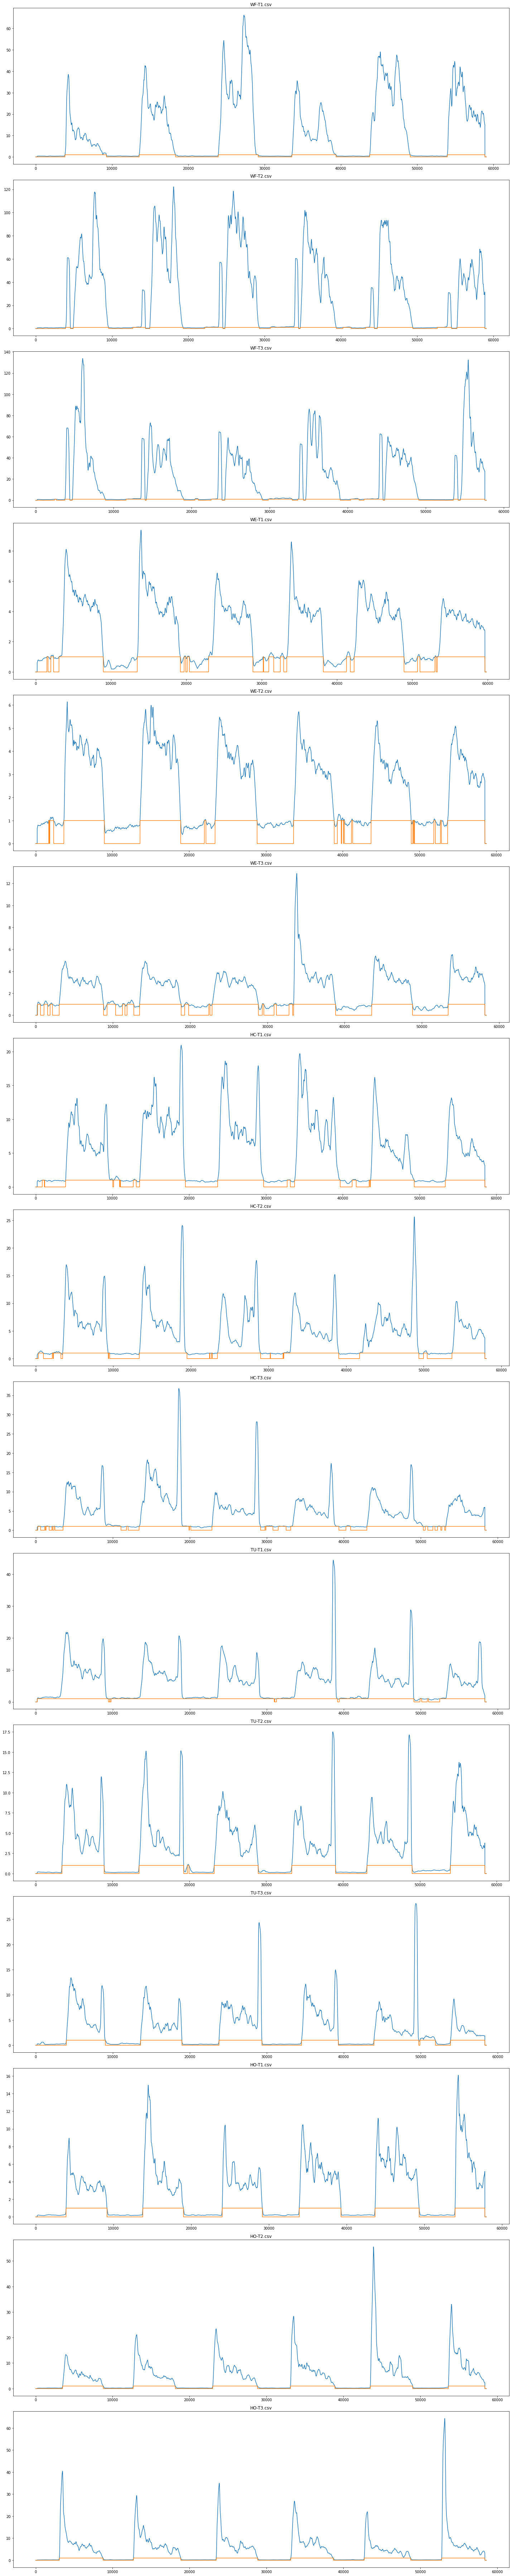

In [12]:
onset_sig1 =[]
for sig in sm_sig1:
  #onset.append(signals.emg.find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
  onset_sig1.append(find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
binary_label_sig1 = [get_binary_label_sig(sig, set_det.all()) for sig, set_det in zip(sm_sig1, onset_sig1)]
visualize_binary_sigs(binary_label_sig1,sm_sig1)

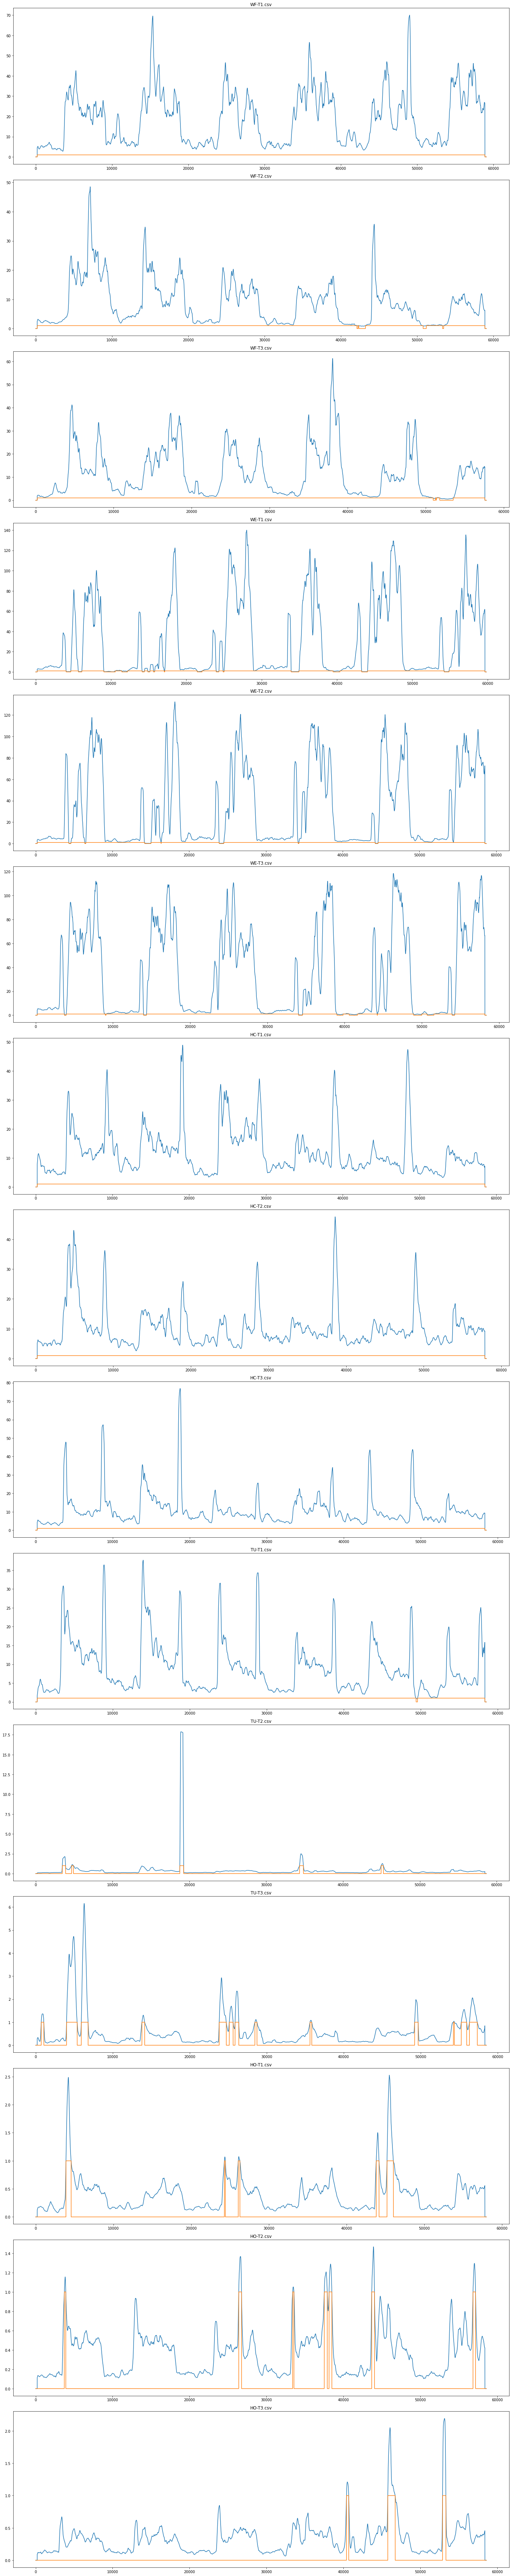

In [13]:
onset_sig2 =[]
for sig in sm_sig2:
  #onset.append(signals.emg.find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
  onset_sig2.append(find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
binary_label_sig2 = [get_binary_label_sig(sig, set_det.all()) for sig, set_det in zip(sm_sig2, onset_sig2)]
visualize_binary_sigs(binary_label_sig2,sm_sig2)

In [14]:
for i,s in enumerate(binary_label_sig1):
  count1_ch1 = binary_label_sig1[i].count(1)
  count0_ch1 = binary_label_sig1[i].count(0)
  sub_ch1=abs(count1_ch1-count0_ch1)
  count1_ch2 = binary_label_sig2[i].count(1)
  count0_ch2 = binary_label_sig2[i].count(0)
  sub_ch2=abs(count1_ch2-count0_ch2)
  if(sub_ch1<sub_ch2):
    print("channel1 ---> gesture "+titles[i].strip('.csv'))
  else:
    print("channel2 ---> gesture "+titles[i].strip('.csv'))
    

channel1 ---> gesture WF-T1
channel1 ---> gesture WF-T2
channel1 ---> gesture WF-T3
channel1 ---> gesture WE-T1
channel1 ---> gesture WE-T2
channel1 ---> gesture WE-T3
channel1 ---> gesture HC-T1
channel1 ---> gesture HC-T2
channel1 ---> gesture HC-T3
channel1 ---> gesture TU-T1
channel1 ---> gesture TU-T2
channel1 ---> gesture TU-T3
channel1 ---> gesture HO-T1
channel1 ---> gesture HO-T2
channel1 ---> gesture HO-T3


In [34]:
for i,s in enumerate(binary_label_sig2):
  count1 = binary_label_sig2[i].count(1)
  count0 = binary_label_sig2[i].count(0)
sub=abs(count1-count0)
print(sub)

26311


AttributeError: ignored

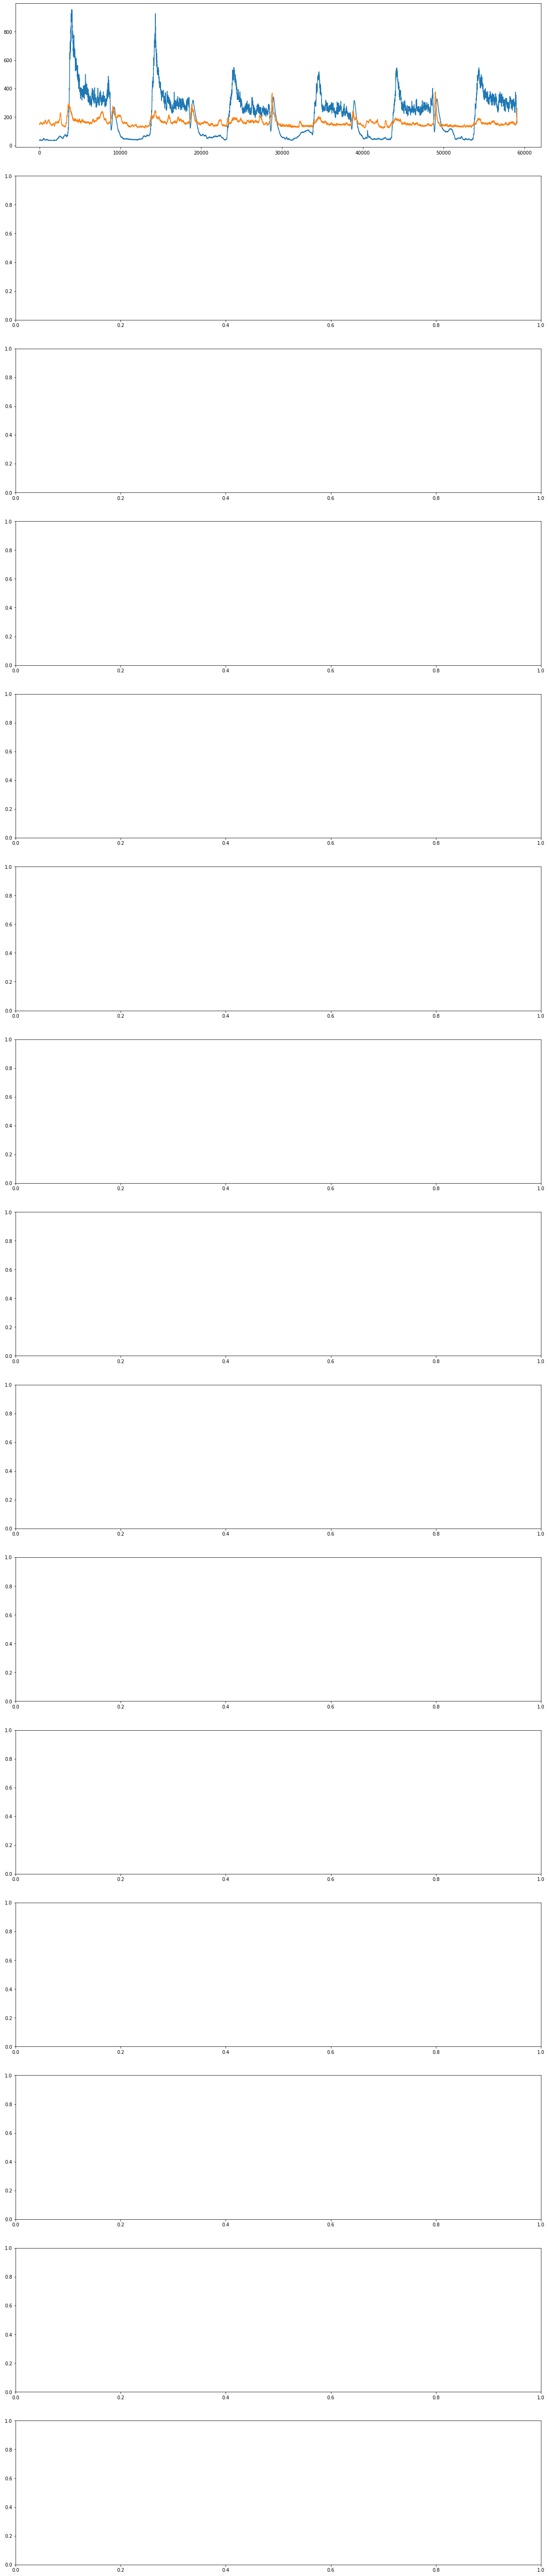

In [22]:
n_plots = len(ch1_sigs)
fig, ax = plt.subplots(n_plots, 1, figsize = (20,100))
for i in range(n_plots):
    ax[i].plot(ch1_sigs[i])
    ax[i].plot(ch2_sigs[i])
    ax[i].axhline(binary_label_sig1[i].all(), color='red')
    ax[i].axhline(binary_label_sig2[i], color='yellow')
    ax[i].set_title(titles[i])

In [ ]:
!pip install neurokit2
import neurokit2 as nk

In [ ]:

!pip install biosppy
from biosppy import signals as signals

In [23]:
for sig in sm_sig:
  emg_cleaned = nk.emg_process(sig)
  #emg_amplitude = nk.emg_amplitude(emg_cleaned)

# Threshold method
  # activity, info = nk.emg_activation(emg_amplitude=emg_amplitude, method="threshold")
  # fig = nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], sig)
  # fig 
